<a href="https://colab.research.google.com/github/Navya-prasad/YOLOv8n-based-Driver-Monitoring-System/blob/main/drowsiness_webcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17516, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 17516 (delta 8), reused 0 (delta 0), pack-reused 17494 (from 3)
Receiving objects: 100% (17516/17516), 16.62 MiB | 24.49 MiB/s, done.
Resolving deltas: 100% (12004/12004), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 

In [ ]:
import torch
import cv2
import numpy as np
from IPython.display import display, Javascript, Image, clear_output
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image as PILImage


In [ ]:
model_path = "/content/drive/MyDrive/Research and Projects/Colab Notebooks/Untitled" # This path was incorrect

# Load a pre-trained YOLOv5 model (e.g., 'yolov5s')
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-7-30 Python-3.11.13 torch-2.6.0+cu124 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [ ]:
def start_webcam():
    display(Javascript('''
        async function streamWebcam() {
          const video = document.createElement('video');
          const div = document.createElement('div');
          const stopBtn = document.createElement('button');
          stopBtn.textContent = 'Stop Webcam';
          stopBtn.style.marginTop = '10px';

          const stream = await navigator.mediaDevices.getUserMedia({ video: true });
          video.srcObject = stream;
          await video.play();

          div.appendChild(video);
          div.appendChild(stopBtn);
          document.body.appendChild(div);

          const canvas = document.createElement('canvas');
          const context = canvas.getContext('2d');
          canvas.width = 640;
          canvas.height = 480;

          let stop = false;
          stopBtn.onclick = () => stop = true;

          while (!stop) {
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            const imageData = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('notebook.frame_handler', [imageData], {});
            await new Promise(resolve => setTimeout(resolve, 500));
          }

          stream.getTracks().forEach(track => track.stop());
          div.remove();
        }
        streamWebcam();
    '''))


In [ ]:
from google.colab import output

def handle_frame(data_url):
    # Step 1: Decode base64 webcam image to OpenCV frame
    header, encoded = data_url.split(",", 1)
    decoded = b64decode(encoded)
    np_arr = np.frombuffer(decoded, np.uint8)
    frame = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)

    # Step 2: YOLOv5 Inference
    results = model(frame)

    # Step 3: Render annotated image
    results.render()  # modifies results.ims in place
    img = PILImage.fromarray(results.ims[0])  # numpy to PIL

    # Step 4: Display in cell
    clear_output(wait=True)
    display(img)

# Register this handler for webcam input
output.register_callback('notebook.frame_handler', handle_frame)


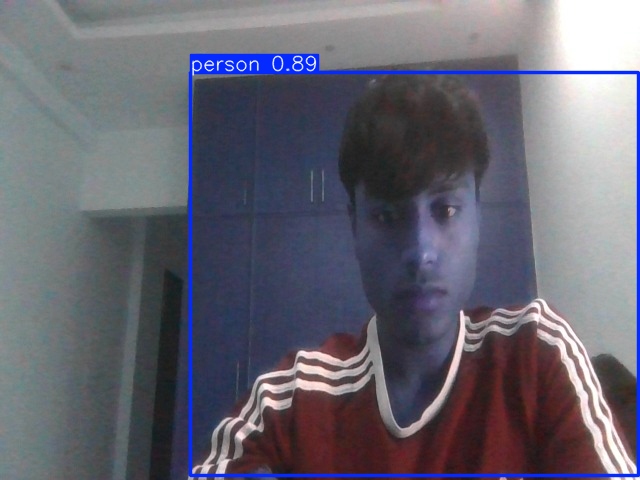

In [ ]:
start_webcam()


In [ ]:
# 📦 Required libraries
import cv2
import time
from datetime import datetime
from ultralytics import YOLO
import os

# 🧠 Load YOLOv5 trained model (replace with your actual path)
model = YOLO('best.pt')  # Make sure 'best.pt' is in your working directory

# 📄 Initialize logging
log_file = open("drowsiness_log.csv", "a")
if log_file.tell() == 0:
    log_file.write("timestamp,status\n")

# 🎯 Class Labels
class_names = model.names  # Assumes labels: 'Open Eyes' and 'Closed Eyes'

# 🚨 Drowsiness tracking
drowsy_frame_count = 0
awake_frame_count = 0
alert_triggered = False
start_drowsy_time = None

# 🎥 Open webcam
cap = cv2.VideoCapture(0)  # 0 for default camera

if not cap.isOpened():
    print("❌ Cannot open webcam")
    exit()

print("📷 Webcam started. Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("❌ Failed to grab frame")
        break

    # 🧠 Run YOLO model
    results = model(frame, verbose=False)
    detections = results[0].boxes.data
    is_drowsy = False

    for det in detections:
        x1, y1, x2, y2, conf, cls = det[:6]
        label = class_names[int(cls)]

        if label.lower() == "closed eyes":
            is_drowsy = True
            break

    # 🕒 Time tracking
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    if is_drowsy:
        if start_drowsy_time is None:
            start_drowsy_time = time.time()
        drowsy_frame_count += 1
        awake_frame_count = 0
        elapsed = time.time() - start_drowsy_time

        if elapsed >= 2 and not alert_triggered:
            print("🚨 ALERT: DROWSINESS DETECTED!")
            alert_triggered = True

            # 🔊 Optional: Play alert sound if on local machine
            try:
                import playsound
                playsound.playsound('alarm.mp3')  # Add alarm.mp3 to working dir
            except:
                print("🔇 Unable to play sound (install playsound or check file)")

        log_file.write(f"{timestamp},DROWSY\n")

    else:
        awake_frame_count += 1
        drowsy_frame_count = 0
        start_drowsy_time = None
        alert_triggered = False
        log_file.write(f"{timestamp},AWAKE\n")

    # 🖼️ Annotate and display
    status_text = "DROWSY" if is_drowsy else "AWAKE"
    color = (0, 0, 255) if is_drowsy else (0, 255, 0)
    cv2.putText(frame, status_text, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 3)

    cv2.imshow("Driver Monitor", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

log_file.close()
cap.release()
cv2.destroyAllWindows()
